## Project: Bayesian Non-Parametric Models for Stock Prediction

#### Team Members:
- Asteria Xu (56376452)
- Yufei Shen (29116514)

In [1]:
library(tidyverse) 
library(ggplot2)
library(fGarch)
library(rstan)   

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
NOTE: Packages 'fBasics', 'timeDate', and 'timeSeries' are no longer
attached to the search() path when 'fGarch' is attached.

If needed attach them yourself in your R script by e.g.,
        require("timeSeries")

Loading required package: StanHeaders


rstan version 2.32.7 (Stan version 2.32.2)


For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we 

In [2]:
# Load data
tsla_data <- read.csv("TSLA.csv") %>% 
  mutate(Date = as.Date(Date)) %>%
  arrange(Date) %>%  # Ensure chronological order
  tail(1 * 252) %>%  # Approximately 3 years of trading days
  mutate(Returns = c(NA, diff(log(Close)))) %>%
  na.omit()
head(tsla_data)

,Date,Open,High,Low,Close,Adj.Close,Volume,Returns
,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>
2706,2021-03-29,615.64,616.48,596.02,611.29,611.29,28637000,-0.0120652586
2707,2021-03-30,601.75,637.66,591.01,635.62,635.62,39432400,0.0390294503
2708,2021-03-31,646.62,672.00,641.11,667.93,667.93,33337300,0.0495824745
2709,2021-04-01,688.37,692.42,659.42,661.75,661.75,35298400,-0.0092955260
2710,2021-04-05,707.71,708.16,684.70,691.05,691.05,41842800,0.0433243216
2711,2021-04-06,690.30,696.55,681.37,691.62,691.62,28271800,0.0008245019


In [3]:
# Split into train and test sets
train_size <- floor(0.8 * nrow(tsla_data))
train_data <- tsla_data[1:train_size, ]
test_data <- tsla_data[(train_size+1):nrow(tsla_data), ]

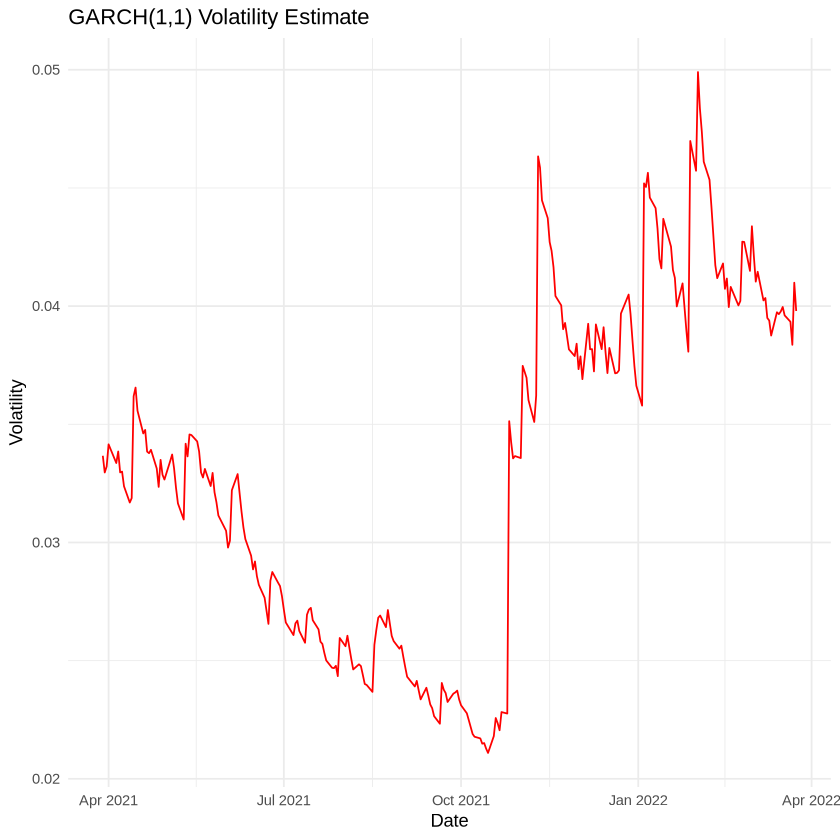

In [4]:
# Fit GARCH(1,1)
fit <- garchFit(~ garch(1,1), data = train_data$Returns, trace = FALSE)

# Extract volatility
vol_series <- volatility(fit)

# Coerce to numeric and trim to match length
vol_vector <- as.numeric(vol_series)

# Align lengths
tsla_data <- tail(tsla_data, length(vol_vector))
tsla_data$GARCH_vol <- vol_vector

# Plot
ggplot(tsla_data, aes(x = Date, y = GARCH_vol)) +
  geom_line(color = "red") +
  labs(
    title = "GARCH(1,1) Volatility Estimate",
    x = "Date",
    y = "Volatility"
  ) +
  theme_minimal()

In [5]:
# Prepare data for Stan GP model - convert dates to numeric array
stan_data <- list(
  N = nrow(train_data),
  x = as.array(1:nrow(train_data)),  # Numeric index
  y = train_data$Returns,
  N_pred = nrow(test_data),
  x_pred = as.array((nrow(train_data)+1):(nrow(train_data)+nrow(test_data)))
)

# Standardize returns before fitting
train_mean <- mean(train_data$Returns)
train_sd <- sd(train_data$Returns)
stan_data$y <- (train_data$Returns - train_mean)/train_sd

# Run with more iterations and control settings
gp_model <- stan(
  file = "gp_model.stan",
  data = stan_data,
  chains = 2,        # More chains for better diagnostics
  iter = 1000,       # More iterations
  warmup = 500,     # Longer warmup
  cores = 2,
  control = list(adapt_delta = 0.9,  # Increase to reduce divergences
                 max_treedepth = 12)
)

# When extracting predictions, remember to unstandardize:
gp_samples <- extract(gp_model)
gp_pred_mean <- apply(gp_samples$f_pred, 2, mean) * train_sd + train_mean
gp_pred_sd <- apply(gp_samples$f_pred, 2, sd) * train_sd

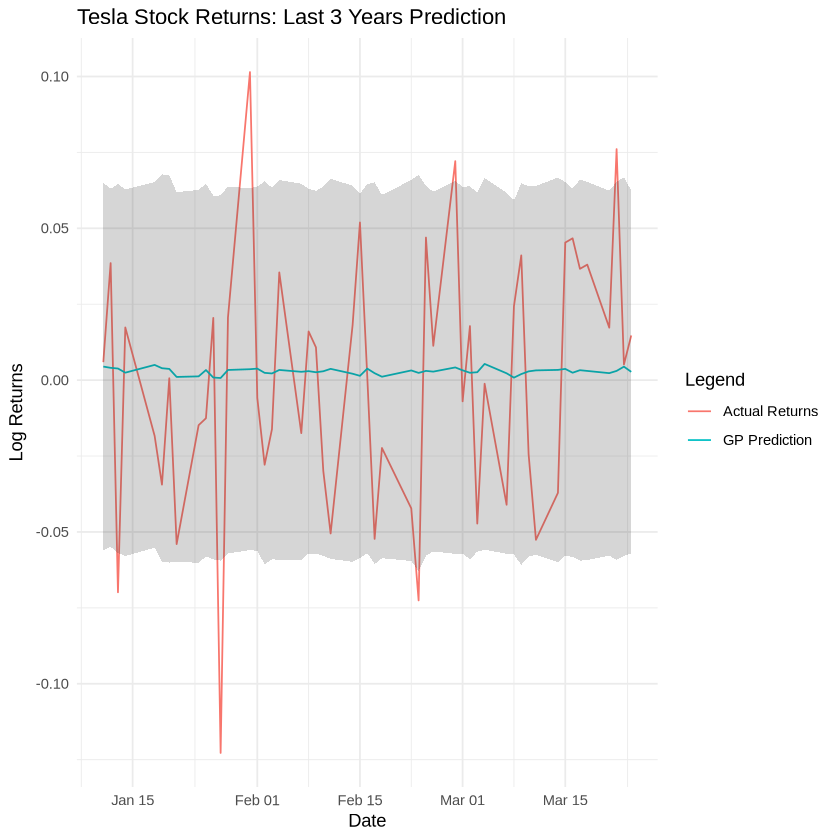

In [6]:
# Create results dataframe
results <- data.frame(
  Date = test_data$Date,
  Actual = test_data$Returns,
  Predicted = gp_pred_mean,
  Lower = gp_pred_mean - 1.96 * gp_pred_sd,
  Upper = gp_pred_mean + 1.96 * gp_pred_sd
)

# Plot results
ggplot(results, aes(x = Date)) +
  geom_line(aes(y = Actual, color = "Actual Returns")) +
  geom_line(aes(y = Predicted, color = "GP Prediction")) +
  geom_ribbon(aes(ymin = Lower, ymax = Upper), alpha = 0.2) +
  labs(title = "Tesla Stock Returns: Last 3 Years Prediction",
       y = "Log Returns",
       color = "Legend") +
  theme_minimal()